The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 注意力提示
:label:`sec_attention-cues`

感谢你对本书的关注，因为注意力是一种稀缺的资源：此刻你正在阅读这本书而忽略了其他的书。因此，你的注意力是用机会成本（与金钱类似）来支付的。为了确保你现在投入的注意力是值得的，我们尽全力（全部的注意力）创作一本好书。

自经济学研究稀缺资源分配以来，我们正处在注意力经济时代，即人类的注意力被视为可以交换的、有限的、有价值的且稀缺的商品。许多商业模式也被开发出来去利用这个商业模式。在音乐或视频流媒体服务上，我们要么消耗注意力在广告上，要么付钱来隐藏广告。为了在网络游戏世界的成长，我们要么消耗注意力在战斗中，从而帮助吸引新的玩家，要么付钱立即变得强大。没什么是免费的。

总而言之，注意力在我们的环境中是稀缺的，而环境中的信息却并不少。在检查视觉场景时，我们的视觉神经系统大约每秒收到 $10^8$ 位的信息，这远远超过了大脑能够完全处理的水平。幸运的是，我们的祖先已经从经验（也称为数据）中认识到 *并非感官的所有输入都是一样的*。在整个人类历史中，这种只将注意力引向感兴趣的一小部分信息的能力，使我们的大脑能够更明智地分配资源来生存、成长和社交，例如发现天敌、找寻食物和伴侣。

## 生物学中的注意力提示

为了解释我们的注意力是如何在视觉世界中展开的，一个双组件（two-component）的框架应运而生，并得到了普及。这个框架的出现可以追溯到 19 世纪 90 年代的威廉·詹姆斯，他被认为是 “美国心理学之父” :cite:`James.2007` 。在这个框架中，受试者基于 *非自主性提示* 和 *自主性提示* 有选择地引导注意力的焦点。

非自主性提示是基于环境中物体的突出性和易见性。想象一下，你面前有五个物品：一份报纸、一篇研究论文、一杯咖啡、一本笔记本和一本书，就像 :numref:`fig_eye-coffee` 。所有纸制品都是黑白印刷的，但咖啡杯是红色的。换句话说，这杯咖啡在这种视觉环境中是突出和显眼的，自动而且不由自主地引起人们的注意。所以你把 fovea（黄斑中心，视力最敏锐的地方）放到咖啡上，如 :numref:`fig_eye-coffee` 所示。

![使用基于突出性的非自主性提示（红杯子，而非纸张），注意力不自主地指向了咖啡。](../img/eye-coffee.svg)
:width:`400px`
:label:`fig_eye-coffee`

喝咖啡后，你会变得兴奋并想读书。所以你转过头，重新聚焦你的眼睛，然后看看书，就像 :numref:`fig_eye-book` 中描述那样。与 :numref:`fig_eye-coffee` 中由于突出性导致选择会偏向于咖啡不同，此时选择书是受到了认知和意识的控制，因此注意力在基于自主性提示去辅助选择时将更为谨慎。受试者的主观意愿推动，选择的力量也就更强大。

![通过使用依赖于任务的意志提示（想读一本书），注意力被自主引导的书上。](../img/eye-book.svg)
:width:`400px`
:label:`fig_eye-book`

## 查询、键和值

自主性的与非自主性的注意力提示解释了注意力的方式，下面我们将描述设计注意力机制时的框架，框架中合并这两个注意力提示来设计注意力机制。

首先，考虑一个相对简单的状况，即只使用非自主性提示。要想将选择偏向于感官输入，我们可以简单地使用参数化的全连接层，甚至是非参数化的最大汇聚层或平均汇聚层。

因此，通过是否包含自主性提示将注意力机制与全连接层或汇聚层区别开来。在注意力机制的背景下，我们将自主性提示称为 *查询*（Queries）。给定任何查询，注意力机制通过 *注意力汇聚*（attention pooling）将选择偏向于 *感官输入*（sensory inputs，例如中间特征表示）。在注意力机制的背景下，这些感官输入被称为 *值*（Values）。更通俗的解释，每个值都与一个 *键*（Keys） 配对，这可以想象为感官输入的非自主提示。如 :numref:`fig_qkv` 所示，我们可以设计注意力汇聚，以便给定的查询（自主性提示）可以与键（非自主性提示）进行交互，这将引导将选择偏向于值（感官输入）。

![注意力机制通过注意力汇聚将 *查询*（自主性提示）和 *键*（非自主性提示）结合在一起，实现对 *值*（感官输入）的选择倾向。](http://d2l.ai/_images/qkv.svg)
:label:`fig_qkv`

注意，注意力机制的设计有许多替代方案。例如，我们可以设计一个不可微的注意力模型，该模型可以使用强化学习方法 :cite:`Mnih.Heess.Graves.ea.2014` 进行训练。鉴于上面所提框架在 :numref:`fig_qkv` 中的主导地位，因此这个框架下的模型将成为本章我们关注的中心。

## 注意力的可视化

平均汇聚层可以被视为输入的加权平均值，其中各输入的权重是一样的。实际上，注意力汇聚得到的是加权平均的总和值，其中权重是在给定的查询和不同的键之间计算得出的。


In [1]:
import torch
from d2l import torch as d2l

为了可视化注意力权重，我们定义了 `show_heatmaps` 函数。其输入 `matrices` 的形状是 (要显示的行数，要显示的列数, 查询的数目, 键的数目)。


In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

我们使用一个简单的例子进行演示。在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。


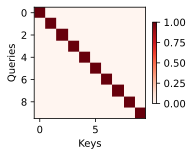

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

在后面的章节中，我们将经常调用此函数来显示注意力权重。

## 小结

* 人类的注意力是有限的、有价值和稀缺的资源。
* 受试者使用非自主性和自主性提示有选择性地引导注意力。前者基于突出性，后者则依赖于任务。
* 注意力机制与全连接层或者汇聚层的区别源于增加的自主提示。
* 由于包含了自主性提示，注意力机制与全连接的层或汇聚层不同。
* 注意力机制通过注意力汇聚使选择偏向于值（感官输入），其中包含查询（自主性提示）和键（非自主性提示）。键和值是成对的。
* 我们可以可视化查询和键之间的注意力权重。

## 练习

1. 在机器翻译中通过解码序列标记时，其自主性提示可能是什么？非自主性提示和感官输入又是什么？
1. 随机生成一个 $10 \times 10$ 矩阵并使用 `softmax` 运算来确保每行都是有效的概率分布，然后可视化输出注意力权重。


[Discussions](https://discuss.d2l.ai/t/1592)
